# コード9-1：ランダムフォレストの実装

『ウイルス感染の数理モデルとシミュレーション ーデータを定量的に理解するー』

ランダムフォレストの実装の例をまとめる。

- randomForest rdocumentation  
https://www.rdocumentation.org/packages/randomForest/versions/4.7-1.1/topics/randomForest
- pROC rdocumentation  
https://www.rdocumentation.org/packages/pROC/versions/1.18.5

In [15]:
# install.packages(c("randomForest", "pROC", "dplyr"))

In [2]:
library(randomForest)
library(pROC)
library(dplyr)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var



Attaching package: ‘dplyr’


The following object is masked from ‘package:randomForest’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## データ

感染症に関する臨床データは、一般に完全な形で公開されることが少ないので、生成した仮想のデータセットを使用します。

In [3]:
data_sample <- read.csv("../../data/09_01/data_09_01.csv")
head(data_sample)

,id,severity,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,⋯,item_101,item_102,item_103,item_104,item_105,item_106,item_107,item_108,item_109,item_110
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,Severe,0.1529537,0.9268564,0.2158215,0.2700058,0.7643882,3.2510863,0.4256630,1.0713519,⋯,16470.2895,9.039882,594.1458,90.57741,20.165713,1350.84313,22127.840,1.2738598,2497.66738,270.3420
2,2,Severe,1.1187048,0.6952589,1.7719741,1.1213724,0.8634947,0.8192973,0.3132959,1.1956616,⋯,18410.4096,19.023656,356.3089,164.91013,4.322147,835.02067,6997.351,0.9277962,388.21087,556.7280
3,3,Severe,1.2797504,0.1945758,2.2624940,1.1981781,2.0228450,0.1841301,0.5137874,1.1177742,⋯,709.1681,258.795650,1020.1495,19.79672,82.771129,53.90894,10166.751,1.6206560,262.76693,1510.2849
4,4,Severe,0.5092195,1.4808641,0.1682183,1.0000307,1.3890897,1.2496303,0.7876928,0.7833376,⋯,15767.0063,4.486367,1118.2207,40.56327,70.910292,173.75697,1935.488,16.3827302,68.29856,360.6223
5,5,Severe,0.7168618,0.1564217,3.6627513,3.5706942,9.7690373,3.4290642,1.7683730,0.2624204,⋯,60601.0014,13.431952,3151.0889,1.68593,15.361806,392.61304,2313.305,0.7270797,287.98559,659.8424
6,6,Severe,3.1009301,0.7509750,1.5979396,1.2340669,0.4786526,1.3332308,1.0916687,0.5146522,⋯,9249.6034,310.108026,1123.1782,57.85024,34.748306,142.34622,27949.435,9.5557454,858.08688,394.7040


`item_101`〜`item_110`は`Severe`と`Mild`で異なるようにしているので、これらを使う場合と使わない場合で行います。

In [4]:
## 全データ
set.seed(100)
data_train <- data_sample[c(sample(which(data_sample$severity == "Severe"), 400, replace = F),
                            sample(which(data_sample$severity == "Mild"), 400, replace = F)), ]
data_test <- subset(data_sample, !(id %in% data_train$id))

print("train data")
print(dim(data_train))
print(head(data_train[, 1:6]))
print("test data")
print(dim(data_test))
print(head(data_test[, 1:6]))
print("id重複確認")
print(length(which(data_train$id %in% data_test$id)) > 0)

## severityに関連する項目を除外
data_train_random <- data_train[, -(103:112)]
data_test_random <- data_test[, -(103:112)]

[1] "train data"
[1] 800 112
     id severity    item_1    item_2    item_3    item_4
202 202   Severe 1.2604210 1.2148805 0.2483481 0.3970651
358 358   Severe 4.8168657 5.0320053 3.8548352 1.1054881
112 112   Severe 0.8458864 2.0218116 0.2255148 1.2486708
473 473   Severe 0.4942741 1.1502509 0.5566262 0.9534933
206 206   Severe 0.1395678 1.1585343 2.0069394 1.4148489
492 492   Severe 0.4062299 0.3513698 0.5356444 2.0120865
[1] "test data"
[1] 200 112
   id severity      item_1    item_2    item_3     item_4
5   5   Severe  0.71686179 0.1564217 3.6627513  3.5706942
8   8   Severe  0.06396508 1.5810730 1.9200410  0.6055357
10 10   Severe 10.56831235 1.0654013 0.9604963  0.8460543
18 18   Severe  0.45921024 3.0092121 9.0032499  0.3813848
24 24   Severe  0.43085938 0.2197772 2.5661802  1.3106756
29 29   Severe  1.09038377 0.5405473 0.9487138 10.5544279
[1] "id重複確認"
[1] FALSE


## 分類問題

In [5]:
model_rf <- randomForest(formula = factor(severity) ~ ., data = data_train[, -1], importance = TRUE, proximity = TRUE)
print(model_rf)

model_rf_random <- randomForest(formula = factor(severity) ~ ., data = data_train_random[, -1], importance = TRUE, proximity = TRUE)
print(model_rf_random)


Call:
 randomForest(formula = factor(severity) ~ ., data = data_train[,      -1], importance = TRUE, proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 10

        OOB estimate of  error rate: 0%
Confusion matrix:
       Mild Severe class.error
Mild    400      0           0
Severe    0    400           0

Call:
 randomForest(formula = factor(severity) ~ ., data = data_train_random[,      -1], importance = TRUE, proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 10

        OOB estimate of  error rate: 49.62%
Confusion matrix:
       Mild Severe class.error
Mild    202    198      0.4950
Severe  199    201      0.4975


## ランダムフォレストの変数重要度

In [6]:
head(importance(model_rf))

,Mild,Severe,MeanDecreaseAccuracy,MeanDecreaseGini
item_1,2.2955979,-1.3996821,0.8596603,0.3248178
item_2,0.3343030,-0.7841415,-0.5195590,0.3566361
item_3,0.9370422,-0.6861884,0.2494438,0.2722413
item_4,-0.9963645,-0.8015932,-1.2797614,0.2861182
item_5,-1.1635442,0.7755947,-0.2135808,0.2165807
item_6,1.7601971,1.3469242,2.3233063,0.4796265


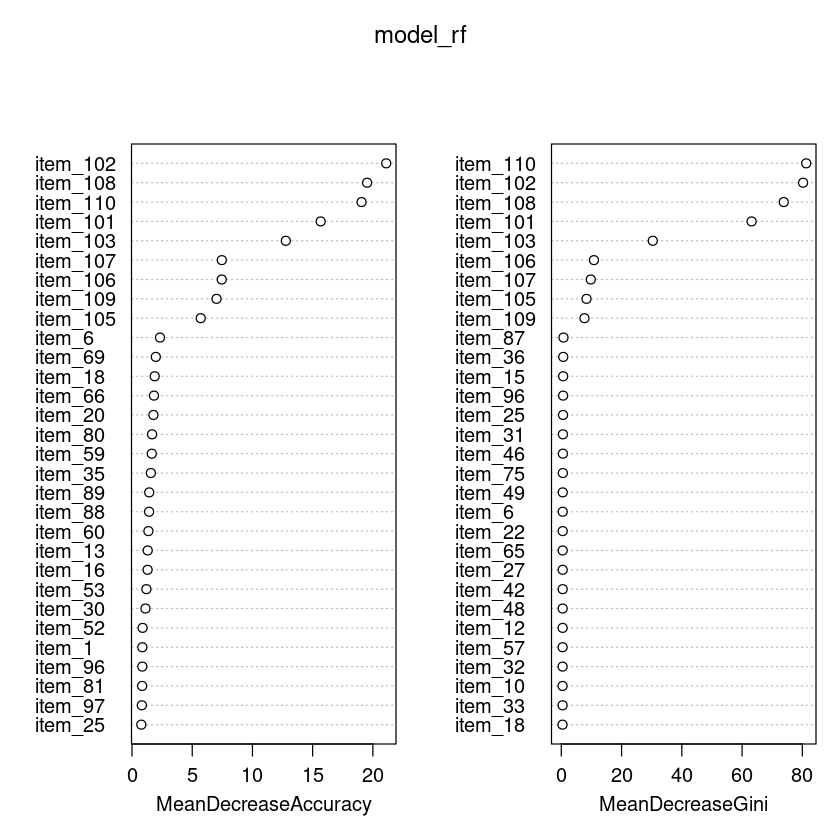

In [7]:
varImpPlot(model_rf)

In [8]:
head(importance(model_rf_random))

,Mild,Severe,MeanDecreaseAccuracy,MeanDecreaseGini
item_1,-0.2359227,-0.7113495,-0.6897932,4.069706
item_2,-0.3526963,-0.5282856,-0.5773693,3.765242
item_3,0.1870321,0.7645947,0.5813277,3.380893
item_4,-0.8391036,-0.7124114,-1.0146482,3.643735
item_5,0.6764762,-2.5724378,-1.1346736,3.543527
item_6,-0.8615321,0.2490511,-0.5070398,4.554014


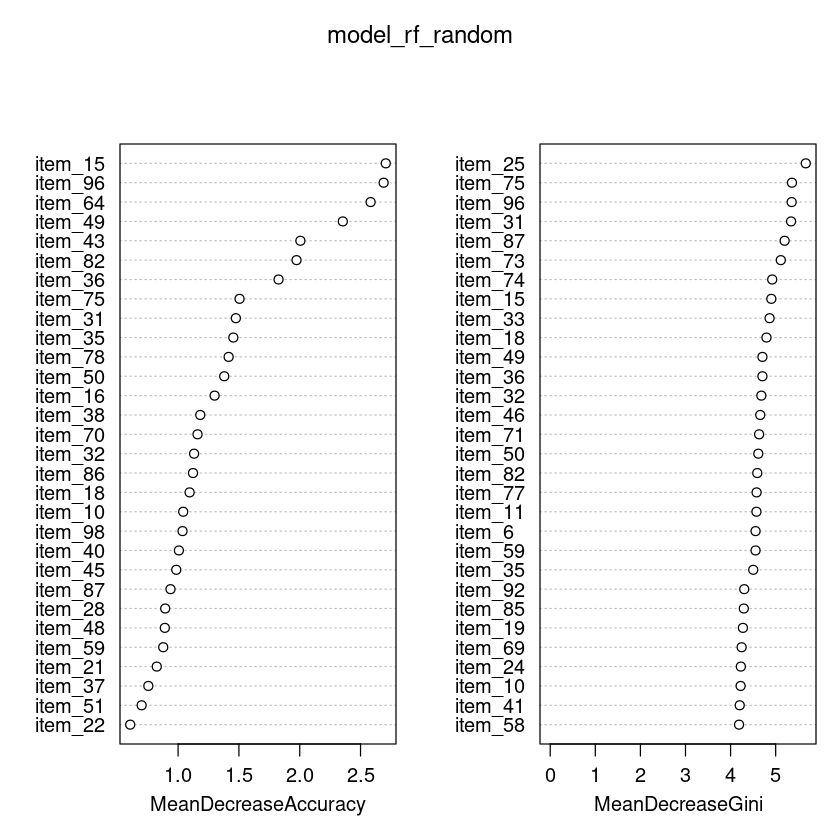

In [9]:
varImpPlot(model_rf_random)

## テスト

In [10]:
prediction_rf <- as.data.frame(predict(model_rf, data_test[, -1], type = "prob"))
prediction_rf <- mutate(prediction_rf, prediction = ifelse(Mild > Severe, "Mild", "Severe"))
prediction_rf$observed <- data_test$severity
head(prediction_rf)

,Mild,Severe,prediction,observed
,<dbl>,<dbl>,<chr>,<chr>
5,0.030,0.970,Severe,Severe
8,0.034,0.966,Severe,Severe
10,0.028,0.972,Severe,Severe
18,0.050,0.950,Severe,Severe
24,0.014,0.986,Severe,Severe
29,0.054,0.946,Severe,Severe


In [11]:
prediction_rf_random <- as.data.frame(predict(model_rf_random, data_test_random[, -1], type = "prob"))

In [12]:
test_roc <- roc(data_test$severity, prediction_rf[, 2])
test_roc_random <- roc(data_test_random$severity, prediction_rf_random[, 2])

Setting levels: control = Mild, case = Severe

Setting direction: controls < cases

Setting levels: control = Mild, case = Severe

Setting direction: controls > cases



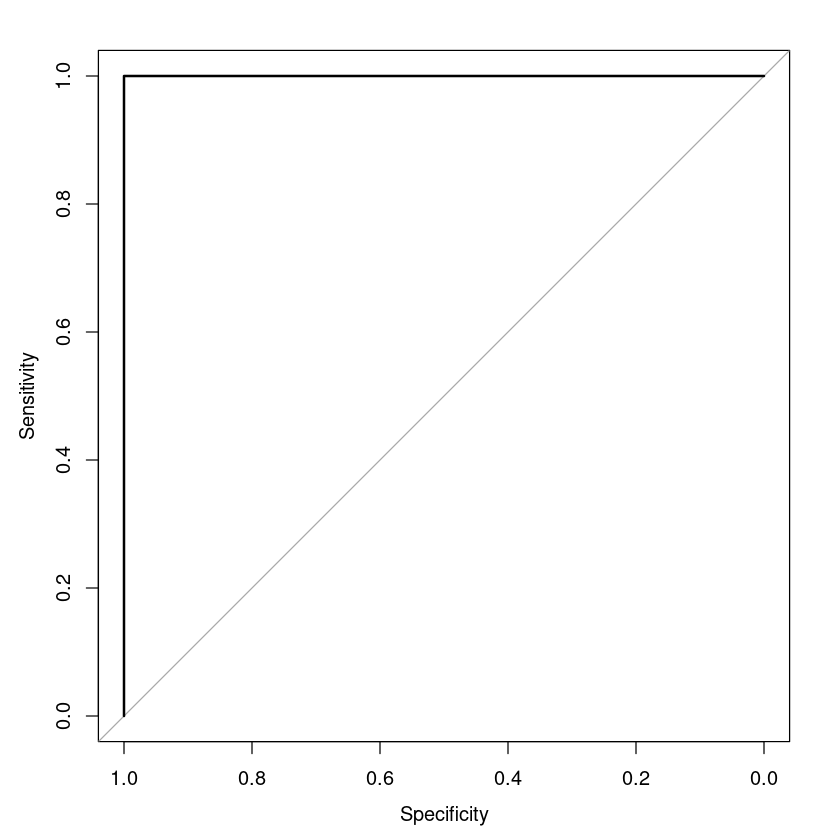

In [13]:
plot(test_roc)

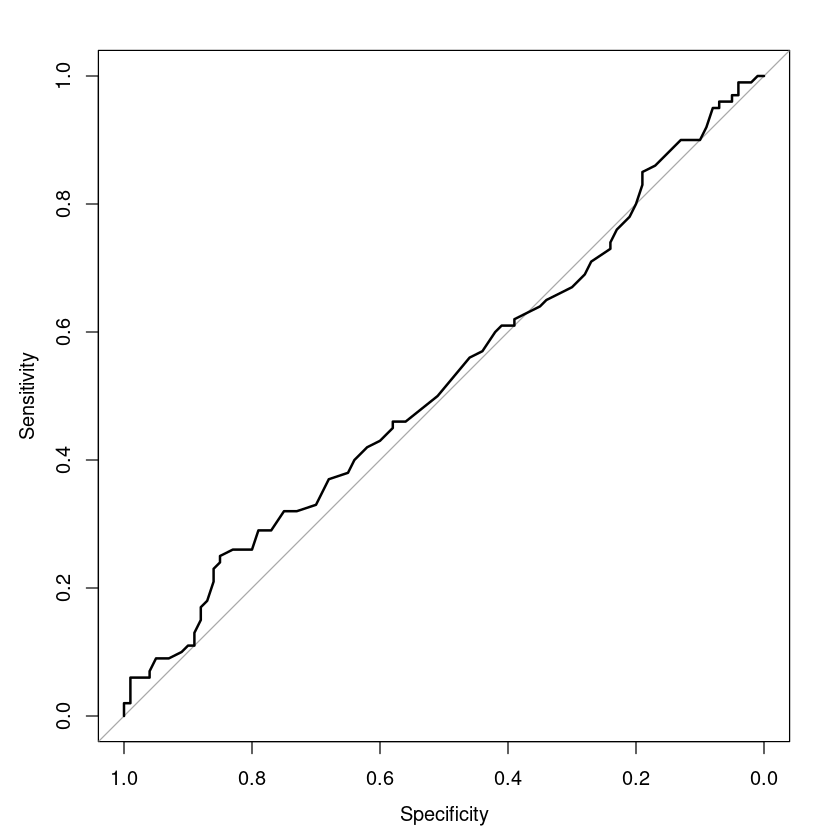

In [14]:
plot(test_roc_random)